In [15]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
!cp -r /content/drive/MyDrive/Data/MN /content/

Load data and preprocess

In [17]:
import matplotlib.pyplot as plt
import random

def show_samples(images, labels, samples_per_class=5):
    unique_labels = np.unique(labels)
    num_classes = len(unique_labels)

    plt.figure(figsize=(samples_per_class * 2, num_classes * 2))

    for i, label in enumerate(unique_labels):
        idxs = np.where(labels == label)[0]
        chosen = np.random.choice(idxs, samples_per_class, replace=False)

        for j, idx in enumerate(chosen):
            plt_idx = i * samples_per_class + j + 1
            plt.subplot(num_classes, samples_per_class, plt_idx)
            plt.imshow(images[idx], cmap='gray')
            plt.axis('off')

            if j == 0:
                plt.ylabel(f"Class {label}")

    plt.tight_layout()
    plt.show()


In [18]:
from skimage.io import imread
from skimage.color import rgb2gray, rgba2rgb
from skimage.transform import resize
from skimage.filters import threshold_otsu
from skimage.feature import hog
from scipy.ndimage import center_of_mass, shift
import numpy as np
import os

def preprocess_digit(img):
    # Grayscale
    if img.ndim == 3:
        if img.shape[2] == 4:
            img = rgba2rgb(img)
        img = rgb2gray(img)

    # Normalize 0-1
    img = (img - img.min()) / (img.max() - img.min() + 1e-8)

    # Threshold (Otsu)
    thresh = threshold_otsu(img)
    img = img > thresh
    img = img.astype(np.float32)

    # Ensure digit is white
    if np.mean(img) > 0.5:
        img = 1 - img

    # Bounding box crop
    coords = np.column_stack(np.where(img > 0))
    if coords.shape[0] == 0:
        return np.zeros((28, 28))  # tránh crash nếu ảnh trống

    y_min, x_min = coords.min(axis=0)
    y_max, x_max = coords.max(axis=0)

    digit = img[y_min:y_max+1, x_min:x_max+1]

    # Resize digit to 20x20
    digit = resize(digit, (20, 20), anti_aliasing=True)

    # Pad to 28x28
    canvas = np.zeros((28, 28))
    canvas[4:24, 4:24] = digit

    # Center shift (center of mass)
    cy, cx = center_of_mass(canvas)
    shift_y = 14 - cy
    shift_x = 14 - cx
    canvas = shift(canvas, (shift_y, shift_x))

    return canvas


def load_and_extract_hog(base_path):
    X = []
    y = []
    processed_images = []

    for label in range(10):
        class_dir = os.path.join(base_path, str(label))

        for file in os.listdir(class_dir):
            img_path = os.path.join(class_dir, file)
            img = imread(img_path)

            # Preprocess digit
            img = preprocess_digit(img)

            processed_images.append(img)

            # HOG
            features = hog(
                img,
                orientations=9,
                pixels_per_cell=(4, 4),
                cells_per_block=(2, 2),
                block_norm='L2-Hys'
            )

            X.append(features)
            y.append(label)

    return np.array(X), np.array(y), np.array(processed_images)

DATA_ROOT = "/content/MN"

X, y, imgs = load_and_extract_hog(DATA_ROOT)

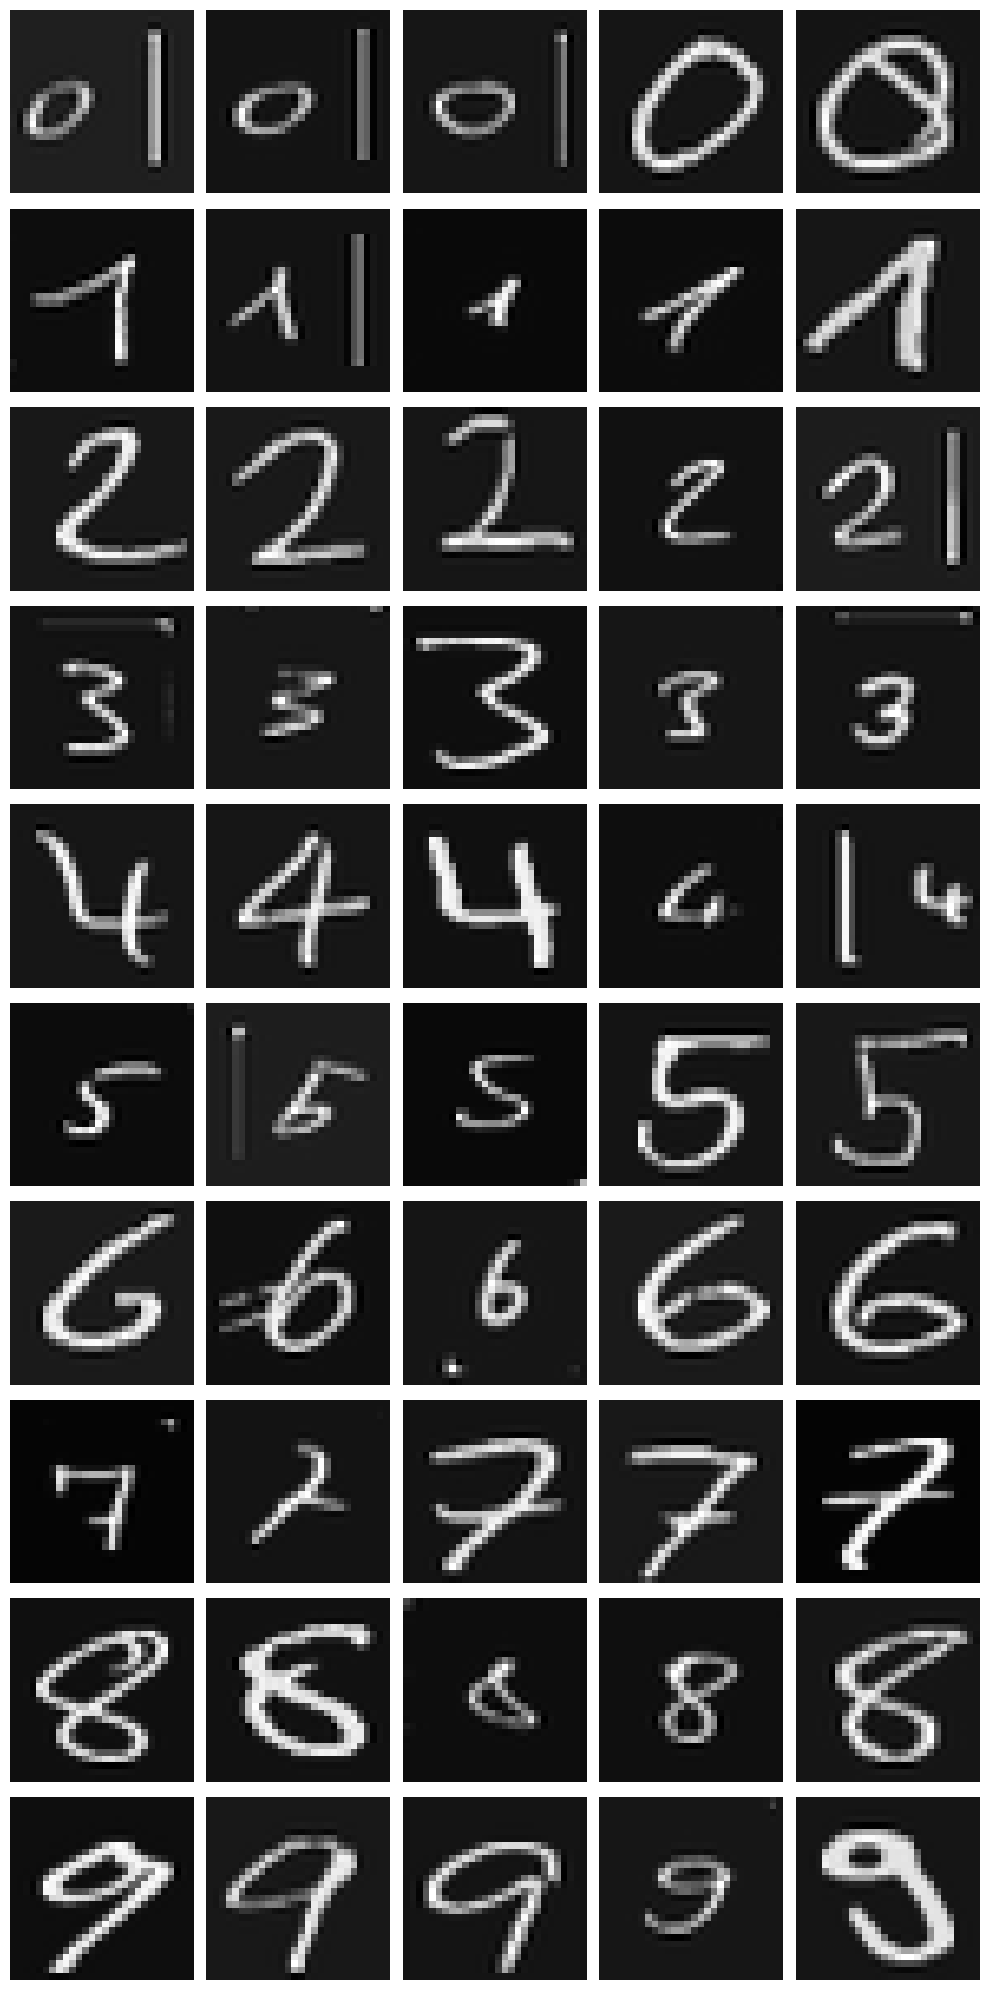

In [19]:
show_samples(imgs, y, samples_per_class=5)

In [20]:
from sklearn.model_selection import train_test_split

# split data
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (17244, 1296)
Test shape: (4312, 1296)


Feature scaling

In [21]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)


SVM

In [22]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale']
}

svm = SVC(kernel='rbf')

grid = GridSearchCV(
    svm,
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)

print("Running GridSearch...")
grid.fit(X_train_scaled, y_train)

print("Best parameters:", grid.best_params_)
print("Best CV accuracy:", grid.best_score_)

Running GridSearch...
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best parameters: {'C': 10, 'gamma': 'scale'}
Best CV accuracy: 0.9628272157974435


Evaluation

In [23]:
best_model = grid.best_estimator_

test_pred = best_model.predict(X_test_scaled)

from sklearn.metrics import accuracy_score, classification_report

print("Test Accuracy:", accuracy_score(y_test, test_pred))
print(classification_report(y_test, test_pred))

Test Accuracy: 0.9649814471243042
              precision    recall  f1-score   support

           0       0.97      0.98      0.97       447
           1       0.97      0.99      0.98       449
           2       0.97      0.97      0.97       447
           3       0.94      0.95      0.95       441
           4       0.96      0.96      0.96       436
           5       0.99      0.96      0.97       425
           6       0.97      0.98      0.97       424
           7       0.98      0.96      0.97       423
           8       0.96      0.94      0.95       417
           9       0.94      0.95      0.94       403

    accuracy                           0.96      4312
   macro avg       0.96      0.96      0.96      4312
weighted avg       0.97      0.96      0.96      4312



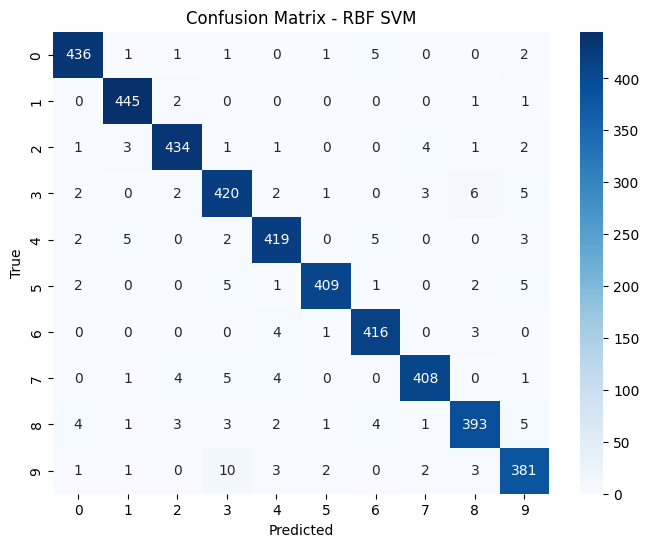

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, test_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - RBF SVM")
plt.show()


Save model

In [25]:
import joblib
import os

SAVE_DIR = "/content/drive/MyDrive/Models"
os.makedirs(SAVE_DIR, exist_ok=True)

# Best trained SVM model
best_model = grid.best_estimator_

# Save
joblib.dump(best_model, os.path.join(SAVE_DIR, "svm_hog_model.joblib"))
joblib.dump(scaler, os.path.join(SAVE_DIR, "scaler.joblib"))

print("Model and scaler saved successfully!")


Model and scaler saved successfully!


Test

Predicted digit: 0


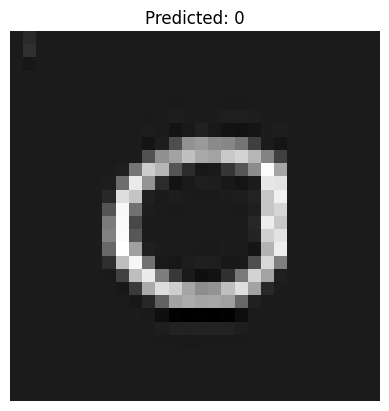

In [26]:
import numpy as np
import matplotlib.pyplot as plt

from skimage.io import imread
from skimage.color import rgb2gray, rgba2rgb
from skimage.transform import resize
from skimage.feature import hog
import joblib
from sklearn.metrics import accuracy_score

model = joblib.load("/content/drive/MyDrive/Models/svm_hog_model.joblib")
scaler = joblib.load("/content/drive/MyDrive/Models/scaler.joblib")

# Load image and preprocess
img_path = "/content/drive/MyDrive/Data/MN/0/Zero_full (1001).jpg"
img = imread(img_path)

# Grayscale
if img.ndim == 3:
    if img.shape[2] == 4:
        img = rgba2rgb(img)
    img = rgb2gray(img)

# Normalize 0-1
img = (img - img.min()) / (img.max() - img.min() + 1e-8)

# Threshold (Otsu)
thresh = threshold_otsu(img)
img = img > thresh
img = img.astype(np.float32)

# Ensure digit is white
if np.mean(img) > 0.5:
    img = 1 - img

# Bounding box crop
coords = np.column_stack(np.where(img > 0))

y_min, x_min = coords.min(axis=0)
y_max, x_max = coords.max(axis=0)

digit = img[y_min:y_max+1, x_min:x_max+1]

# Resize digit to 20x20
digit = resize(digit, (20, 20), anti_aliasing=True)

# Pad to 28x28
canvas = np.zeros((28, 28))
canvas[4:24, 4:24] = digit

# Center shift (center of mass)
cy, cx = center_of_mass(canvas)
shift_y = 14 - cy
shift_x = 14 - cx
canvas = shift(canvas, (shift_y, shift_x))

# HOG
features = hog(
    canvas,
    orientations=9,
    pixels_per_cell=(4, 4),
    cells_per_block=(2, 2),
    block_norm='L2-Hys'
)
hog_features = features.reshape(1, -1)
hog_scaled = scaler.transform(hog_features)

# Predict
prediction = best_model.predict(hog_scaled)

print("Predicted digit:", prediction[0])

# Show image
plt.imshow(canvas, cmap='gray')
plt.title(f"Predicted: {prediction[0]}")
plt.axis("off")
plt.show()

Test with another dataset

In [27]:
from skimage.io import imread
from skimage.color import rgb2gray, rgba2rgb
from skimage.transform import resize
from skimage.filters import threshold_otsu
from skimage.feature import hog
from scipy.ndimage import center_of_mass, shift
import numpy as np
import os

def preprocess_digit(img):
    # Grayscale
    if img.ndim == 3:
        if img.shape[2] == 4:
            img = rgba2rgb(img)
        img = rgb2gray(img)

    # Normalize
    img = (img - img.min()) / (img.max() - img.min() + 1e-8)

    # Threshold
    thresh = threshold_otsu(img)
    img = img > thresh
    img = img.astype(np.float32)

    # Ensure digit is white
    if np.mean(img) > 0.5:
        img = 1 - img

    # Bounding box crop
    coords = np.column_stack(np.where(img > 0))
    if coords.shape[0] == 0:
        return np.zeros((28, 28))

    y_min, x_min = coords.min(axis=0)
    y_max, x_max = coords.max(axis=0)

    digit = img[y_min:y_max+1, x_min:x_max+1]

    # Resize to 20x20
    digit = resize(digit, (20, 20), anti_aliasing=True)

    # Pad to 28x28
    canvas = np.zeros((28, 28))
    canvas[4:24, 4:24] = digit

    # Center shift
    cy, cx = center_of_mass(canvas)
    shift_y = 14 - cy
    shift_x = 14 - cx
    canvas = shift(canvas, (shift_y, shift_x))

    return canvas


def load_and_extract_hog(base_path):
    X = []
    y = []
    processed_images = []

    for label in range(10):
        class_dir = os.path.join(base_path, str(label))

        for file in os.listdir(class_dir):
            img_path = os.path.join(class_dir, file)
            img = imread(img_path)

            img = preprocess_digit(img)
            processed_images.append(img)

            # HOG
            features = hog(
                img,
                orientations=9,
                pixels_per_cell=(4, 4),
                cells_per_block=(2, 2),
                block_norm='L2-Hys'
            )

            X.append(features)
            y.append(label)

    return np.array(X), np.array(y), np.array(processed_images)

TEST_PATH = "/content/drive/MyDrive/Data/MNIST_main/Train"

X_test, y_test, images = load_and_extract_hog(TEST_PATH)

# Scale
X_test_scaled = scaler.transform(X_test)

# Predict
y_pred = best_model.predict(X_test_scaled)

# Evaluate
acc = accuracy_score(y_test, y_pred)

print("\nTest Accuracy:", acc)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Test Accuracy: 0.9110699397869384

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       210
           1       0.94      0.58      0.72       210
           2       0.85      0.98      0.91       218
           3       0.95      0.99      0.97       230
           4       0.98      0.98      0.98       220
           5       0.97      1.00      0.98       215
           6       1.00      1.00      1.00       210
           7       0.98      0.65      0.78       218
           8       0.92      0.97      0.94       216
           9       0.69      0.98      0.81       212

    accuracy                           0.91      2159
   macro avg       0.92      0.91      0.91      2159
weighted avg       0.92      0.91      0.91      2159


Confusion Matrix:
[[206   2   0   0   0   0   0   0   2   0]
 [  4 122  39  13   4   3   1   2  13   9]
 [  0   1 213   0   1   0   0   1   1   1]
 [  0   0   0 227   0   2   0   0 

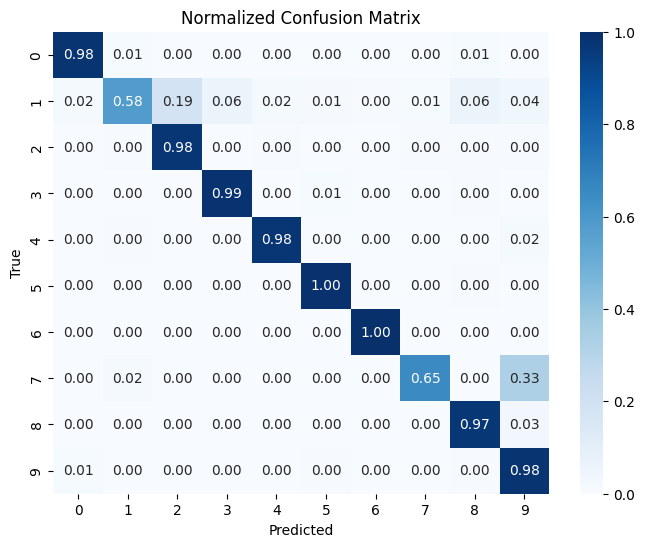

In [28]:
import seaborn as sns
cm_norm = confusion_matrix(y_test, y_pred, normalize='true')

plt.figure(figsize=(8,6))
sns.heatmap(cm_norm,
            annot=True,
            fmt=".2f",
            cmap="Blues")

plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Normalized Confusion Matrix")
plt.show()